# TP 05 : Régularisation et sélection d'attributs

Binômes :
- Binôme 1 : HABELHAMES Khadidja
- Binôme 2 : AIT ABD ERRAHIM Hamou

## I. Implémentation

Dans cette partie, on va implémenter deux fonctions de régularisation et deux fonctions de filtrage. 
La régularisation sera appliquée sur la régression logistique binaire dont le code est fourni ici.


In [19]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline


# Le code de la réression logistique 

# Somme pondérée des caractéristiques
def zf(X, theta):
    return np.dot(X, theta)

# Transformation d'une valeur à une probabilité
def sg(Z):
    return  1 / (1 + np.exp(-Z))

def hf(X, theta):
    return sg(zf(X, theta))

# Fonction objective
# utilisation d'un petit nombre pour éviter log(0)
def BCE(Y, H, e=1e-8): 
    return - np.mean(Y * np.log(H) + (1-Y) * np.log(1-H))  

# Fonction des gradients
def dBCE(X, Y, H):
    return  np.dot(X.T, H-Y)/X.shape[0]

# Fonction de mise à jour des paramètres
def majTheta(Theta, Gradient, alpha): 
    return Theta - alpha * Gradient


### I.1.  Régularisation (Ridge)


#### I.2.1. Fonction du coût de la régularisation L2

La fonction du coût utilisée de la régularisation **L2** est donnée somme : 

$$J_{L2}(\theta) = \frac{\lambda }{2M} \sum\limits_{j=1}^{N} \theta_j^2$$

- **M** : nombre des échantiollons (observations)
- **N** : nombre des caractéristiques


**Remarque** Dans les énoncés, la régularisation n'est pas divisée par le nombre des échantillons $M$. Mais, en pratique, on la divise. [Voici des réponses sur stackexchange](https://stats.stackexchange.com/questions/287920/regularisation-why-multiply-by-1-2m) expliquant pourquoi.

In [20]:
# TODO Réaliser la fonction du coût de la régularisation L2
def J_L2(Theta, M, Lambda=0.):
    
    return (Lambda / (2 * M)) * (np.sum(np.square(np.delete(Theta,0))))

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.0, 0.0005050000000000001)
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais


J_L2(Theta_t, 4), J_L2(Theta_t, 4, Lambda=.4)

(0.0, 0.0005050000000000001)

#### 1.2.2. Gradients de la régularisation L2

La fonction des gradientsde la régularisation **L2** est définie comme suit :
 
$$\frac{\partial J_{L2}(\theta)}{\partial \theta_j} = \frac{\lambda }{M} \theta_j \text{ si } j > 0$$

$$\frac{\partial J_{L2}(\theta)}{\partial \theta_0} = 0$$

- **X** : matrice (échantillons X caractéristiques)
- **Y** : vecteur des sorties réelles (échantillons)
- **H** : vecteur des estimations (échantillons)
- **M** : nombre des échantillons


In [21]:
# TODO Réaliser la fonction du gradient de la régularisation L2
def dJ_L2(Theta, M, Lambda=0.):
    Gr= (Lambda/M) * Theta
    Gr[0]=0
    return Gr


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais

dJ_L2(Theta_t, 4), dJ_L2(Theta_t, 4, Lambda=0.4)

(array([0., 0., 0.]), array([0.   , 0.001, 0.01 ]))

### I.2.  Régularisation (Lasso)

#### I.2.1. Fonction du coût de la régularisation L1

La fonction du coût de la régularisation **L1** sur cette fonction, on aura : 

$$J_{L1}(\theta) = \frac{\lambda}{M} \sum\limits_{j=1}^{N} |\theta_j|$$

- **M** : nombre des échantiollons (observations)
- **N** : nombre des caractéristiques

In [22]:
# TODO Réaliser la fonction du coût de la régularisation L1
def J_L1(Theta, M, Lambda=0.):
    return (Lambda/M) * (np.sum(np.abs(np.delete(Theta,0))))

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.0, 0.011000000000000001)
#---------------------------------------------------------------------

Theta_t = np.array([1, 0.01, 0.1]) # Theta avec le premier élément pour le biais

J_L1(Theta_t, 4), J_L1(Theta_t, 4, Lambda=.4)

(0.0, 0.011000000000000001)

#### I.2.2. Mise à jour des paramètres 

Le dérivé de $L1$ est :
$$\frac{\partial L1}{\partial \theta_j} = \frac{\partial \frac{\lambda }{M} \sum\limits_{j=1}^{N} |\theta_j|}{\partial \theta_j} = \frac{\lambda }{M} \frac{\theta_j}{|\theta_j|}$$

Il est clair que le gradient n'est pas définit dans le cas $\theta_j = 0$. 
En appliquant [le sous-différentiel](https://fr.wikipedia.org/wiki/Sous-diff%C3%A9rentiel), on aura : 
$$
\frac{\partial L1}{\partial \theta_j} = 
\begin{cases}
-\frac{\lambda}{M} & \text{si } \theta_j < 0 \\
0 & \text{si } \theta_j = 0 \\
\frac{\lambda}{M} & \text{si } \theta_j > 0 \\
\end{cases}
$$

On ne peut pas utiliser la descente du gradient pour résoudre ça. 
On va utiliser un alorithme de descente du gradient approximative, qui s'appelle **Iterative soft-thresholding algorithm (ISTA)**. 
$$prox(\theta) = S_{\lambda}(\theta) = 
\begin{cases}
\theta_j + \lambda & \text{si } \theta_j < - \lambda \\
0 & \text{si } -\lambda \le \theta_j \le \lambda \\
\theta_j - \lambda & \text{si } \theta_j > \lambda \\
\end{cases}
$$

**Vous devez implémenter cette fonction**

Les thétas sont mises à jour comme suite : 
$$ \theta = S_{\lambda}(\theta - \frac{\partial J_0}{\partial \theta})$$
Où, $J_0$ est la fonction du coût sans régularisation

Source : [Ryan Tibshirani (2015), Lecture 08: Proximal Gradient Descent](https://www.stat.cmu.edu/~ryantibs/convexopt-S15/scribes/08-prox-grad-scribed.pdf)

In [23]:
# TODO Réaliser la fonction soft-thresholding : prox(theta)
def S(Theta, Lambda): 
    res=[]
    for i in range(len(Theta)):
        if(Theta[i]<=Lambda):
            res.append(Theta [i]+Lambda)
        else:
            if (-Lambda<=Theta[i]<=Lambda):
                res.append(0)
            else : res.append(Theta[i]-Lambda)
            res[0]=Theta[0]    
    return np.array(res)
     

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : array([ 0.5 , -0.15,  0.  ])
#---------------------------------------------------------------------

                     
Theta_t = np.array([0.5, -0.25, 0.05])

S(Theta_t, 0.1)

array([ 0.5 , -0.15,  0.15])

### I.3. Régression avec réglularisation

**Rien à programmer ici**


In [24]:
def descente(X, Y, Theta, approx=False, it_max=100, alpha=0.1, Lambda=0.): 

    M = len(Y)
    
    if approx :
        def maj(Theta, J, dJ):
            J += J_L1(Theta, M, Lambda=Lambda)
            Theta = majTheta(Theta, dJ, alpha)
            Theta = S(Theta, Lambda/M) # Lamdba doit être divisé sur le nombre des échantillons
            return J, Theta
    else:
        def maj(Theta, J, dJ):
            J += J_L2(Theta, M, Lambda=Lambda)
            dJ += dJ_L2(Theta, M, Lambda=Lambda)
            Theta = majTheta(Theta, dJ, alpha)
            return J, Theta
            
    couts = []
    Thetas = []
    
    #pour ne pas modifier le contenu de Theta en entrée
    Theta = Theta.copy()
    
    # ici, on boucle jusqu'à arriver aux maximum des itérations
    for it in range(it_max):
        H = hf(X, Theta)
        J = BCE(Y, H)
        dJ = dBCE(X, Y, H)
        J, Theta = maj(Theta, J, dJ)
        couts.append(J)
        Thetas.append(Theta.copy())
    
    return Thetas, couts

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([ 0.94839532, -0.56840255,  1.2813832 ]),
#  array([0.07440919, 0.        , 0.        ]),
#  array([ 0.93431089, -0.53451115,  1.03711393]))
#
#---------------------------------------------------------------------

X_t = np.array([
    [1, 1, 0.2],
    [1, 2, 0.1],
    [1, 3, 0.4],
    [1, 4, 0.3]
])

Theta_t = np.array([1., 1., 1.])

Y_t = np.array([1, 0, 1, 0])

# pas de régularisation : Lambda = 0
Theta_P, J_P = descente(X_t, Y_t, Theta_t)
# régularisation L1 : approximation avec lambda
Theta_1, J_1 = descente(X_t, Y_t, Theta_t, approx=S, Lambda=0.1)
# régularisation L2 : lambda sans approximation
Theta_2, J_2 = descente(X_t, Y_t, Theta_t, Lambda=0.1)

Theta_P[-1], Theta_1[-1], Theta_2[-1]


(array([ 0.94839532, -0.56840255,  1.2813832 ]),
 array([ 0.46207341, -0.1590881 ,  0.0415974 ]),
 array([ 0.93431089, -0.53451115,  1.03711393]))

In [25]:
import outils

class RegLogReg(object): # Régression logistique régularisée
    
    # par défaut : pas de régularisation
    def __init__(self, nbr_iter=100, alpha=.01, Lambda=1.0, norm=True, const=True, reg=None): 
        self.nbr_iter = nbr_iter
        self.alpha = alpha
        self.norm = norm
        self.const = const
        self.approx = None
        self.Lambda = Lambda
        if reg == "l1":
            self.approx = S
        elif reg != "l2":
            self.Lambda = 0.
    
    def entrainer(self, X, Y): 
        X_pre, self.mean, self.std = outils.preparer(X, norm=self.norm, const=self.const)
        Theta = outils.generer_uns_1(X_pre.shape[1])#
        self.Thetas, self.couts = descente(X_pre, Y, Theta, 
                                          approx=self.approx, 
                                          it_max=self.nbr_iter, 
                                          alpha=self.alpha, 
                                          Lambda=self.Lambda)
        
    # La prédiction
    # si classes=True elle rend une vecteur de 1 et 0
    # sinon elle rend un vecteur de probabilités
    def predire(self, X, classes=True, seuil=0.5, it=-1):
        X_pre, self.mean, self.std = outils.preparer(X, norm=self.norm, const=self.const, mean=self.mean, std=self.std)
        H = hf(X_pre, self.Thetas[it])
        if classes:
            return (H >= seuil).astype(int)
        return H

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([0.86383643, 0.5273866 , 0.96123235]),
#  array([0.79153709, 0.        , 0.        ]),
#  array([0.8515839 , 0.38351525, 0.7672672 ]),
#  array([0, 0, 1, 1]))
#---------------------------------------------------------------------

X_t = np.array([
    [100, 20],
    [200, 10],
    [300, 40],
    [400, 30]
])

Y_t = np.array([1, 0, 1, 0])

# pas de régularisation
reglog = RegLogReg()
reglog.entrainer(X_t, Y_t)
# régularisation L1
reglog1 = RegLogReg(reg="l1")
reglog1.entrainer(X_t, Y_t)
# régularisation L2
reglog2 = RegLogReg(reg="l2")
reglog2.entrainer(X_t, Y_t)

reglog.Thetas[-1], reglog1.Thetas[-1], reglog2.Thetas[-1], reglog.predire(X_t)

(array([0.86383643, 0.5273866 , 0.96123235]),
 array([0.79943701, 0.19504385, 0.14655409]),
 array([0.8515839 , 0.38351525, 0.7672672 ]),
 array([0, 0, 1, 1]))

### I.4. Filtrage des attributs (ANOVA : Analysis of Variance)

Le nombre des échantillons pour chaque classe est différent. 
Pour cette raison, on va implémenter ANOVA for a CRD (COMPLETELY RANDOM DESIGN). 
On va implémenter l'algorithme expliqué dans [Richard Horsly (2012) COMPLETELY RANDOM DESIGN (CRD)](https://www.ndsu.edu/faculty/horsley/CRD.pdf). 
Pour valider l'implémentation, on va utiliser les mêmes données de la page 10.

#### I.4.1. One way F value pour un seul attribue

pour un attribut donné ($A$), on divise l'ensemble de ses échantillons sur $N$ ensembles, où $N$ est le nombre des classes. 

$$CF = \frac{(\sum_{ij} A_{ij})^2}{\sum_j |A_j|} $$
Où $\sum_{ij} A_{ij}$ est la somme de toutes les valeurs de toutes les classes, 
$\sum_j |A_j|$ est le nombre total des échantillons (de toutes les classes)

$$ TotalSS = \sum_{ij} A_{ij}^2 - CF$$
Où $\sum_{ij} A_{ij}^2$ est les somme des carrées de toutes les valeurs

$$ TreatmentSS = \sum_j \frac{(\sum_{i} A_{ij})^2}{|A_j|} - CF$$
Où $\sum_{i} A_{ij}$ est la somme des valeurs de la classe $j$ et $|A_j|$ est le nombre des éléments dans la classe $j$

$$ ErrorSS = TotalSS - TreatmentSS $$


In [26]:
# TODO Compléter la fonction one-way ANOVA pour un attribut
def f_oneway(A): 
    # A est une liste de N listes où N est le nombre des classes
    # Ces listes n'ont pas la même taille
    nbrs = np.array([len(a) for a in A]) # nombre des échantillons de chaque classe
    sommes = np.array([np.sum(a) for a in A]) # somme des valeurs de chaque classe
    sommes_caree = np.sum([np.sum(np.array(a)**2) for a in A]) # somme des valeurs carrées de toutes les valeurs
    
    # Compléter ici
    #====================================
    CF = (np.sum(sommes) ** 2) / np.sum(nbrs)
    TotalSS = sommes_caree - CF
    TreatmentSS = np.sum([(np.sum(a) ** 2) / len(a) for a in A]) - CF
    ErrorSS = TotalSS - TreatmentSS
    #====================================
    
    MSB = TreatmentSS / (len(A) - 1) 
    MSW =  ErrorSS/(nbrs.sum() - len(A))
    return MSB/MSW


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 6.418894830659841
#---------------------------------------------------------------------

AA = [[2., 2.2, 1.8, 2.3, 1.7], [1.7, 1.9, 1.5], [2., 2.4, 2.7, 2.5, 2.4], [2.1, 2.2, 2.2, 1.9]]
# Résultat : 6.418894830659841 (voir page 11 step 6)
f_oneway(AA)

6.418894830659841

#### I.4.2. One way F value pour tous les attribues

**Rien à programmer ou analyser ici**

Ici, on va calculer ANOVA pour chaque attribut. 
Les attributs avec des grandes valeurs ANOVA sont meilleurs. 



In [27]:
def anova_f(X, Y): 
    
    C = np.unique(Y)
    F = []
    for j in range(X.shape[1]): 
        A = X[:, j]
        F.append(f_oneway([A[Y==c] for c in np.unique(Y)]))
    return np.array(F)


#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array([  6.41889483,   0.40595497, 105.2745098 ]),
#  array([  6.41889483,   0.40595497, 105.2745098 ]))
#---------------------------------------------------------------------

X_t = np.array(
    [[2. , 1. , 1. ],
     [2.2, 2. , 1. ],
     [1.8, 3. , 1. ],
     [2.3, 4. , 1. ],
     [1.7, 5. , 2. ],
     [1.7, 1. , 2. ],
     [1.9, 2. , 2. ],
     [1.5, 3. , 2. ],
     [2. , 1. , 3. ],
     [2.4, 2. , 3. ],
     [2.7, 3. , 3. ],
     [2.5, 4. , 3. ],
     [2.4, 5. , 3. ],
     [2.1, 1. , 4. ],
     [2.2, 2. , 4. ],
     [2.2, 3. , 4. ],
     [1.9, 4. , 4. ]])

Y_t = np.array(["A", "A", "A", "A", "A", "B", "B", "B", "C", "C", "C", "C", "C", "D", "D", "D", "D"])

# pour valider, on va utiliser f_classif de scikit-learn 
# https://github.com/scikit-learn/scikit-learn/blob/95d4f0841d57e8b5f6b2a570312e9d832e69debc/sklearn/feature_selection/_univariate_selection.py#L42
from sklearn.feature_selection import f_classif
f_sklearn, a = f_classif(X_t, Y_t)
# la première liste est celle de scikit-learn et la deuxième est la notre
f_notre = anova_f(X_t, Y_t)

f_sklearn, f_notre

(array([  6.41889483,   0.40595497, 105.2745098 ]),
 array([  6.41889483,   0.40595497, 105.2745098 ]))

## II. Application et analyse

On va utiliser le dataset [Diabetics prediction using logistic regression](https://www.kaggle.com/kandij/diabetes-dataset). 

In [28]:
diabetes = pd.read_csv("datasets/diabetes2.csv") 
X_diabetes = diabetes.iloc[:, :-1].values  
Y_diabetes = diabetes.iloc[:, -1].values

# Cette configuration est mise en place comme ceci exprès
# C'est pour tester le cas où la régression est difavorisée
NBR_TEST = 240
# Supposant que les 30% premières lignes sont pour le test et le reste pour l'entraînement
X_test = X_diabetes[-NBR_TEST:, :] # 30% ou plus
Y_test = Y_diabetes[-NBR_TEST:]

X_train = X_diabetes[:-NBR_TEST, :] 
Y_train = Y_diabetes[:-NBR_TEST]

diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### II.1. Régularisation

Nous avons entrainé 3 modèles :
- **reglog** : régression logistique sans régularisation
- **reglog_l1** : régression logistique avec régularisation L1
- **reglog_l2** : régression logistique avec régularisation L2

Nous avons testé ces modèles en utilisant deux datasets (avec la métrique F1 dans chaque itération) :
- **entrainement** : pour tester la convergence (fitting)
- **test** : pour tester la généralisation

Afin de capturer les F1 scores et les paramètres, nous avons entrainé chaque modèle avec une seule itération et utiliser une boucle globale pour contrôler les traitements de chaque itération. Pour continuer l'entrainement à partir des thétas précédents, nous avons activé l'option **warm_start**. Ceci va générer des graphiques non lisses (puisqu'on lance l'algorithme d'optimisation à chaque itération).

#### II.1.1.  Convergence et généralisation sans et avec régularisation par itérations

Ici, on suppose que l'algorithme a convergé lorsqu'il atteint le maximum de F1 score dans l'antrainement (normalement, il doit sortir s'il y a une chutte de F1 score et retourne les thétats les plus optimaux). Donc, au delà du point de la convergence, nous avons continuer l'itération pour voir ce qui va se passer. 


**Analyser les résultats**

- Que remarquez-vous ?
- Analyser les cas de convergence (qui converge plus rappidement, avec quel prix (quel est le gain ou la perte)) en précisant dans ce cas l'intérêt de la régularisation. 
- Pourquoi les modèles avec régularisation perdent-ils de performance en avançant le nombre des itérations ?

**Réponse**

- Le test de convergence ( fitting) : On remarque que la reglog_l1 converge le plus rapidement  mais elle commence à chuter à partir de l'itération 200 car le modèle a trouvé le thétat optimal rapidement (et elle atteint un F1 score qui egale à 0.47 )  , ensuite vient la reglog_l2 qui converge moins rapidement que la reglog_l1 et qui atteint un nombre max de F1 score qui dépasse 0.50  et qui commence à dégrader , et en dernier vient la Regression sans régularisation qui converge tout au long des itérations ( mais ce modèle risque d'etre éronné).
- Le test de généralisation :  Pour la reglog_l1 on remarque une chute à partir de l'itération 300, pour la reglog_l2 et la regression sans regularisation les graphes sont preque similaires et (sauf que le graphe de regression se stabilise et reglog_l2 commence à se dégrader). 

- On peut dire que le modèle avec régularisation converge plus rapidement : La régularisation consiste à contraindre/régulariser le modèle à partir de l'apprentissage de concepts complexes, réduisant ainsi le risque de surapprentissage ( elle  prévente le sur-apprentissage de notre modèle en le rendant moins sensible aux données de traitements et du coup réduire l'erreur de généralisation), c'est pour ça que la convergence devient plus rapide pour la regression avec régularisation.Mais ça peut dégrader les performances.
Comme comparaison entre L1 et L2, L1 peut mettre les thétas à 0, donc il effectue automatiquement la séléction des attributs en mettant à 0 les coéfficient des attributs colinéaires, contrairement à L2 qui ne peut pas mettre à 0 les coéfficients, et donc L1 converge plus rapidement.

- Les modèles avec régularisation perdent de performance en avançant le nombre des itérations , car lorsqu'une certaine valeur maximale est atteinte pour un certain nombre d'itérations, si le nombre d'itérations augmente encore, le degré de généralisation augmente également,  ce qui peut conduire à un sous-apprentissage.

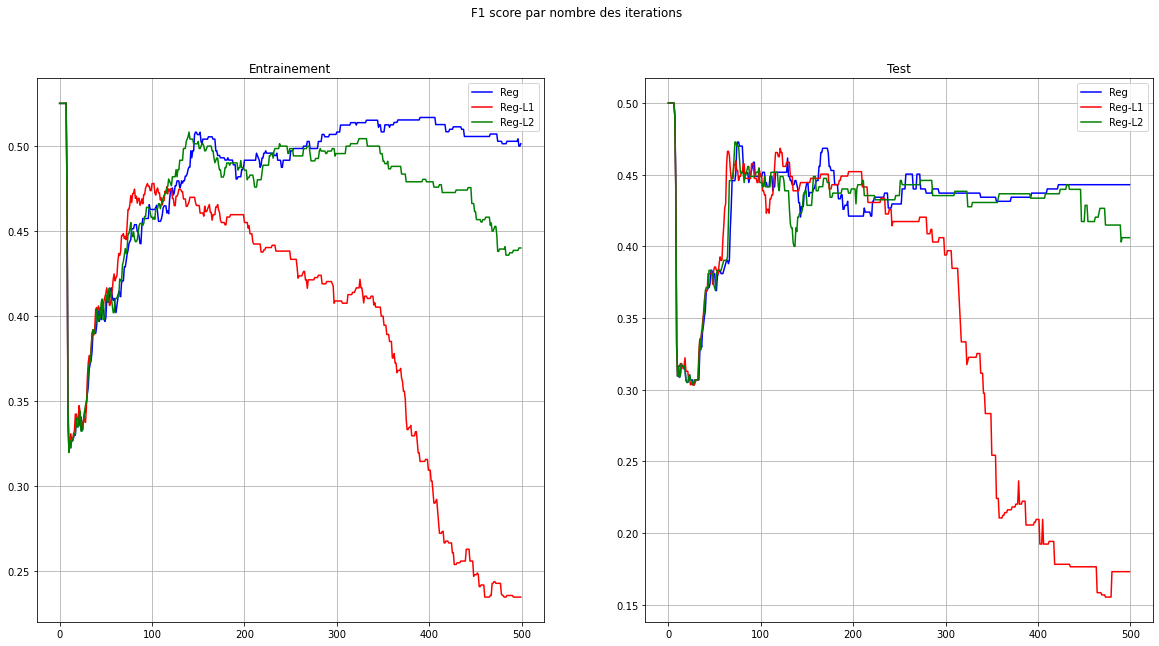

In [52]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore", category=ConvergenceWarning)

MAX_IT = 500
CC = 0.002
COEF_ = np.array([[1.] * X_train.shape[1]])
INTERCEPT_ = np.array([1.])

reglog = LogisticRegression(penalty='none', solver="saga", max_iter=1, warm_start=True, random_state=0)
reglog.coef_ = COEF_
reglog.intercept_ = INTERCEPT_
reglog_l1 = LogisticRegression(penalty='l1', solver="saga", max_iter=1, warm_start=True, random_state=0, C=CC)
reglog_l1.coef_ = COEF_
reglog_l1.intercept_ = INTERCEPT_
reglog_l2 = LogisticRegression(penalty='l2', solver="saga", max_iter=1, warm_start=True, random_state=0, C=CC)
reglog_l2.coef_ = COEF_
reglog_l2.intercept_ = INTERCEPT_

coefs = []
coefs0 =[]
f1train = []
f1test = []

coefs_ridge = []
coefs0_ridge = []
f1train_ridge = []
f1test_ridge = []

coefs_lasso = []
coefs0_lasso = []
f1train_lasso = []
f1test_lasso = []

for it in range(MAX_IT):
    reglog.fit(X_train, Y_train)
    coefs.append(reglog.coef_.flatten().tolist())
    coefs0.append(reglog.intercept_[0])
    f1train.append(f1_score(Y_train, reglog.predict(X_train)))
    f1test.append(f1_score(Y_test, reglog.predict(X_test)))
    
    reglog_l1.fit(X_train, Y_train)
    coefs_lasso.append(reglog_l1.coef_.flatten().tolist())
    coefs0_lasso.append(reglog_l1.intercept_[0])
    f1train_lasso.append(f1_score(Y_train, reglog_l1.predict(X_train)))
    f1test_lasso.append(f1_score(Y_test, reglog_l1.predict(X_test)))
    
    reglog_l2.fit(X_train, Y_train)
    coefs_ridge.append(reglog_l2.coef_.flatten().tolist())
    coefs0_ridge.append(reglog_l2.intercept_[0])
    f1train_ridge.append(f1_score(Y_train, reglog_l2.predict(X_train)))
    f1test_ridge.append(f1_score(Y_test, reglog_l2.predict(X_test)))


coefs = np.array(coefs)
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("F1 score par nombre des iterations")
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(range(MAX_IT), f1train, color="blue", label="Reg")
ax1.plot(range(MAX_IT), f1train_lasso, color="red", label="Reg-L1")
ax1.plot(range(MAX_IT), f1train_ridge, color="green", label="Reg-L2")
ax1.legend()
ax1.set_title("Entrainement")
ax1.grid()

ax2.plot(range(MAX_IT), f1test, color="blue", label="Reg")
ax2.plot(range(MAX_IT), f1test_lasso, color="red", label="Reg-L1")
ax2.plot(range(MAX_IT), f1test_ridge, color="green", label="Reg-L2")
ax2.legend()
ax2.set_title("Test")
ax2.grid()

plt.show()

#### II.1.2. Convergence des paramètres par itérations

Ici, nous avons afficher les valeurs des paramètres thétas pour chaque itération. 

**Analyser les résultats**

- Que remarquez-vous ?
- Analyser la convergence des valeurs des paramètres entre les trois modèles (pourquoi dans les deux modèles avec régularisation, les valeurs se rapprochent plus de 0, pourquoi il y a des paramètres qui convergent plus rappidement que d'autres)
- Est-ce qu'on peut retirer quelques attributs jugés importants par le modèle ? Si oui, lequels ici ? Si non, pourquoi ?
- Est-ce qu'on peut utiliser la régularisation comme sélection d'attribut ? Préciser (avec argumentation)

**Réponse**

- On remarque que les valeurs de théta de certains attributs tend vers 0 (tels que le : "BloodPressure","Insuline" ,"skinThikness"..) , ce qui montre que ces attributs ne sont pas jugés importants pour cette prédiction. On remarque aussi que la valeur de paramètre "DiabetsPidegreFunction" dans les 2 modèles de régression avec régularisation converge plus rapidement que  le modèle sans régularisation qui reste presque stable avec une valeur proche de 1 et de meme les valeurs de paramètre "Pregnancies"  convergent rapidement dans les modeles avec regularisation vers la valeur 0 . Et en comparant les résultats de reg-l1 et reg-l2 on remarque que c'est presque la même chose, sauf que cetaines théta qui tend  vers 0 ne sont pas nul dans la reg-l2, vu que le Ridge regression ne permet pas d'avoir des thétas égaux à 0.
- Oui , On peut retirer quelques attributs jugés importants par le modèle : Pregnancies,DiabetePidereeFunction
- Oui  , on peut utiliser la régularisation comme sélection d'attribut , car elle permet de réduire  le risque de sur-apprentissage par élimination des attributs (forcer les attributs jugés non importants à tendre vers le zero) afin d'assuer une bonne généralisation du modèle à partir des attributs informatifs.

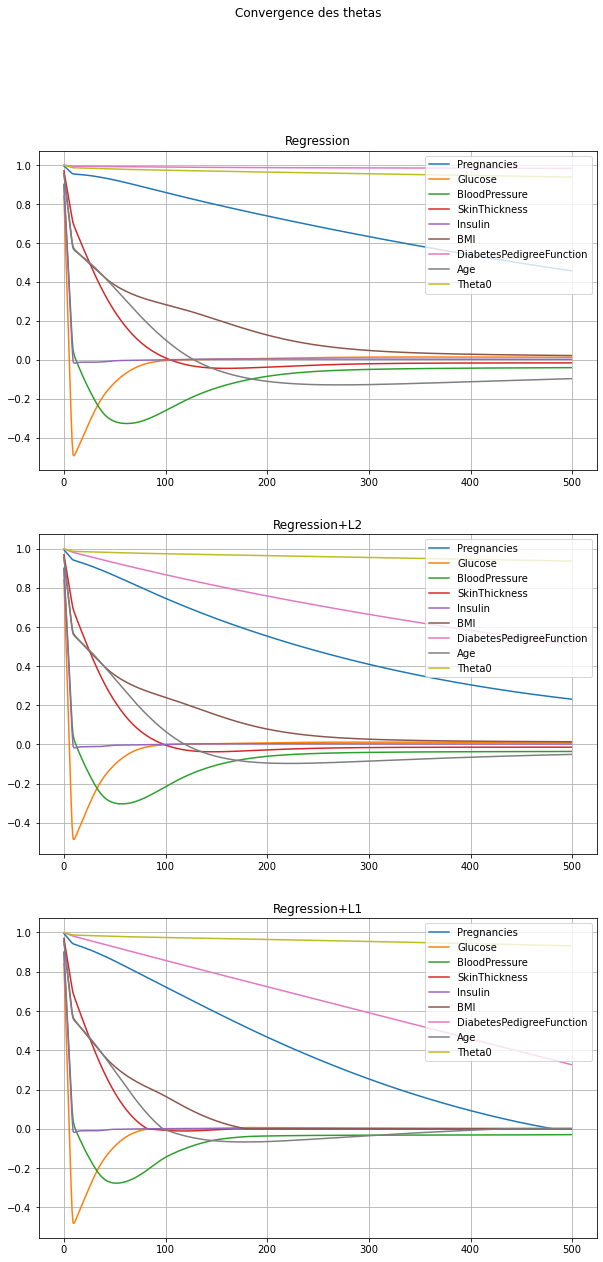

In [53]:
labels = list(diabetes.columns)
labels.pop()
#labels = ["Theta0"] + labels
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.suptitle("Convergence des thetas")
fig.set_figwidth(10)
fig.set_figheight(20)
for i in range(len(labels)): 
    ax1.plot(range(MAX_IT), coefs[:, i], label=labels[i])
    ax3.plot(range(MAX_IT), coefs_lasso[:, i], label=labels[i])
    ax2.plot(range(MAX_IT), coefs_ridge[:, i], label=labels[i])
ax1.plot(range(MAX_IT), coefs0, label="Theta0")
ax2.plot(range(MAX_IT), coefs0_ridge, label="Theta0")
ax3.plot(range(MAX_IT), coefs0_lasso, label="Theta0")
ax1.legend()
ax1.set_title("Regression")
ax1.grid()
ax3.legend()
ax3.set_title("Regression+L1")
ax3.grid()
ax2.legend()
ax2.set_title("Regression+L2")
ax2.grid()

plt.show()

### II.2. Sélection d'attributs

Ici, on va utiliser le même dataset précédent sur plusieurs types de sélection d'attributs.

#### II.2.1. Sélection d'attributs par filtrage (Choix ANOVA)

Nous avons extrait les F values ANOVA pour les différents attributs. 

**Analyser les résultats** 

- Quels sont les attributs les plus importants d'après F values ?
- Pourquoi un attribut est considéré comme important dans ANOVA (aspect mathématique et logique : les valeurs de la'ttribut et de la prédiction Y) ?

**Réponse**

-  Les attributs les plus importants sont le Glucose et le BMI, et puis avec un degré moins important vient le Pregnancies, DiabetePidereeFunction, Age et insulin. Les deux qui restes (BloodPressure et SkinThickness) ne sont pas importants.
- un attribut est representatif/important (bien corrélé) , si les valeurs de la meme classe ont moins de variance (variance intra-classe) et les valeurs des classes ont plus de variance avec le reste (variance inter-classes) Donc, le ratio (variance inter-classes)/(variance intra-classe) doit etre grand (ce ratio s'appele : F-value d’ANOVA ) .


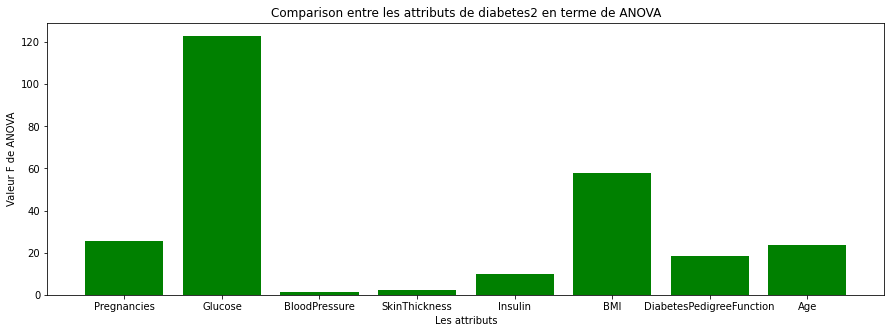

In [54]:
from sklearn.feature_selection import f_classif
f, a = f_classif(X_train, Y_train)

labels_diabetes = list(diabetes.columns[:-1])
x_pos = range(len(f))
plt.figure(figsize=(15,5))
plt.bar(labels_diabetes, f, color="green")
plt.xlabel("Les attributs")
plt.ylabel("Valeur F de ANOVA")
plt.title("Comparison entre les attributs de diabetes2 en terme de ANOVA")

plt.xticks(x_pos, labels_diabetes)

plt.show()


#### II.2.2. Sélection d'attributs par filtrage (Convergence et performance)

Ici, on va utiliser ANOVA pour pré-sélectionner les caractéristiques qui donnent 50% de variance. On veut comparer la convergence du modèle normal contre celui avec pré-sélection ANOVA.

**Analyser les résultats** 

- Pourquoi la performance de la régression sans filtrage est meilleure dans l'entrainement et pas dans et test; et l'inverse pour la régression avec filtrage ? (P.S. on ne parle pas ici du sur-apprentissage; mais des attributs : nombre et qualité)
- Est-ce que le filtrage PEUT prévenir le sur-apprentissage ? Si oui, comment ? Si non, pourquoi ?

**Réponse**

- La regression normale permet d'apprendre les paramètres a partir des données d'entrainement afin de trouver un modèle qui séparent au mieux les classes sans filtrer/choisir les attributs les plus importants .C'est pour cette raison que sa performance diminue dans le test par rapport à l'entraînement.
- Pour la régression avec filtrage , la performance en terme de précision est  moins que sans filtrage , celà est dû à la  perte d'information causé par les attributs filtrés.
- Pour le test comme ce modèle garde que les attributs importants/informatifs donc  l'erreur de généralisation est minimal puisque on risque pas de tester les attributs non importants.

- Oui , le filtrage peut prévenir le sur-apprentissage : Dans la plupart des situations, on se trouve avec un nombre de variables importants ,dont certaines correspondent au bruit, ou elles sont peu informatives,corrélées et redondantes ou meme inutiles, et étant donné que le filtrage consiste à chercher dans l'ensemble des variables disponibles un ensemble optimale des caractéristiques  les plus importants en supprimant les variables fortement corrélées les unes aux autres, il permet donc de réduire la dimension et de  prévenir le sur-apprentissage



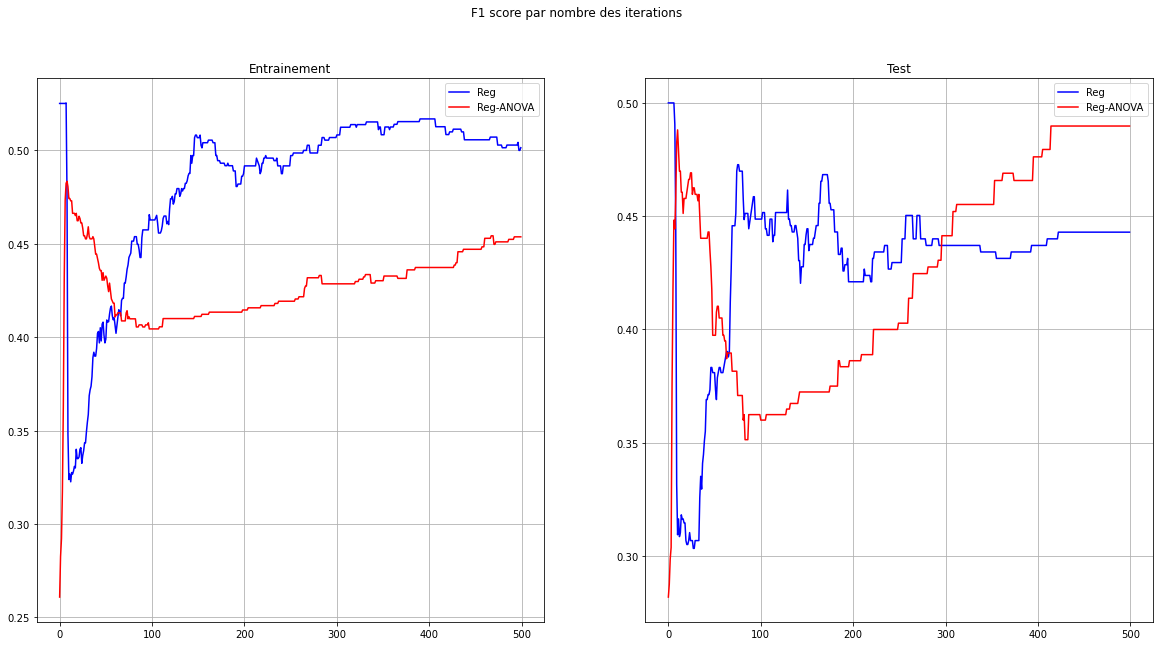

In [61]:
from sklearn.feature_selection import SelectPercentile

selecteur = SelectPercentile(score_func=f_classif, percentile=50)
X_train_new = selecteur.fit_transform(X_train, Y_train)
X_test_new = selecteur.transform(X_test)

reglog_anova = LogisticRegression(penalty='none', solver="saga", max_iter=1, warm_start=True, random_state=0)
reglog_anova.coef_ = np.array([[1.] * X_train_new.shape[1]])
reglog_anova.intercept_ = INTERCEPT_

coefs_anova = []
coefs0_anova =[]
f1train_anova = []
f1test_anova = []

for it in range(MAX_IT):
    reglog_anova.fit(X_train_new, Y_train)
    coefs_anova.append(reglog_anova.coef_.flatten().tolist())
    coefs0_anova.append(reglog_anova.intercept_[0])
    f1train_anova.append(f1_score(Y_train, reglog_anova.predict(X_train_new)))
    f1test_anova.append(f1_score(Y_test, reglog_anova.predict(X_test_new)))

coefs_anova = np.array(coefs_anova)

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle("F1 score par nombre des iterations")
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(range(MAX_IT), f1train, color="blue", label="Reg")
ax1.plot(range(MAX_IT), f1train_anova, color="red", label="Reg-ANOVA")
ax1.legend()
ax1.set_title("Entrainement")
ax1.grid()

ax2.plot(range(MAX_IT), f1test, color="blue", label="Reg")
ax2.plot(range(MAX_IT), f1test_anova, color="red", label="Reg-ANOVA")
ax2.legend()
ax2.set_title("Test")
ax2.grid()

plt.show()

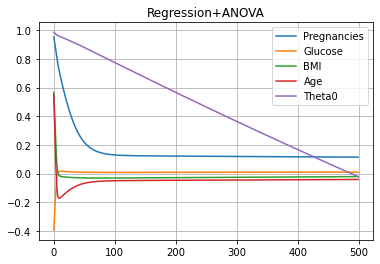

In [64]:
labels_new = selecteur.transform(np.array(diabetes.columns[:-1]).reshape(1, len(diabetes.columns)-1)).flatten()

for i in range(len(labels_new)): 
    plt.plot(range(MAX_IT), coefs_anova[:, i], label=labels_new[i])
plt.plot(range(MAX_IT), coefs0_anova, label="Theta0")
plt.legend()
plt.title("Regression+ANOVA")
plt.grid()
plt.show()

#### II.2.3. Comparaison entre les différentes approches de sélections d'attributs

Ici, on veut comparer des modèles appartenant à des différentes approches de sélection d'attributs : 
- **ANOVA** : c'est une modèle qui utilise la sélection d'attributs par filtrage. Ici, on prend les attributs qui participent de 50% de la variance (4 attributs dans notre cas)
- **L1** : c'est un modèle qui utilise la sélection d'attributs intégrée (embdded)
- **FFS (Forward Features Selection)** : c'est un modèle qui utilise la sélection d'attributs enveloppante (wrapper). Il commence par tester un seul attribut et ajouter d'autres en validant la solution à chaque fois. Ici, nous avons choisi 4 attributs. 
- **BFE (Backward Features Elimination)** : c'est un modèle qui utilise la sélection d'attributs enveloppante (wrapper). Il commence par tester tous les attributs et éliminer d'autres en validant la solution à chaque fois. Ici, nous avons choisi 4 attributs. 

On veut tester les modèles par rapport à celui sans sélection d'attributs en se basant sur les critères suivants :
- **F1 entrainement** : ici on veut répondre à la question "combien un modèle peut-il converger vers sa solution ?"
- **F1 test** : ici on veut répondre à la question "combien un modèle peut-il généraliser ?"
- **Nombre des itérations** : ici on veut répondre à la question "combien faut-il d'itérations pour qu'un modèle converge ?"
- **Temps pré-entrainement** : ici on veut répondre à la question "combien de temps faut-il pour préparer les attributs avant l'entrainement ?"
- **Temps entrainement** : ici on veut répondre à la question "combien de temps faut-il pour l'entrainement ?"

*P.S. L'exécution prend un peu de temps*

**Analyser les résultats** 

- Pourquoi la sélection d'attributs envelopante prend plus de temps d'entrainement portant elle utilise moins d'attributs ? (en se basant sur les résultats)
- Pourquoi la régression avec L1 prend plus de temps d'entrainement que la régression normale portant elle prend moins d'itérations ?
- Pourquoi la sélection d'attributs enveloppante donne des performances mieux que celle par filtrage pourtant cette dernière sélectionne les meilleurs attributs en terme de corrélation ? (dans notre cas, c'est le même nombre d'attributs = 4)
- Si vous avez un dataset avec plusieurs attributs et une quantité énorme d'échantillons, proposer une solution avec moins de temps de pré-entrainement+entrainement et plus de performance (par rapport la solution sans sélection d'attributs) en se basant sur les résultats de cette expérimentation.

**Réponse**

- La sélection d'attributs envelopante prend plus de temps d'entrainement portant elle utilise moins d'attributs car elle utilise un estimateur et essaye de trouver toutes les combinaisons possibles des attributs pour sélectionner la combinaison qui donne des meilleurs résultats .Elle est employé pour évaluer chaque sous ensemble de caractéristiques considéré et elle prend plus d'itérations, donc elle est très coûteuses en terme de  temps d'éxécution.
- La régression avec L1 prend plus de temps d'entrainement que la régression normale car elle effectue des traitements supplémentaires pour la mise à jour des valeurs de theta.
- la sélection d'attributs enveloppante donne des performances mieux que celle par filtrage pourtant cette dernière sélectionne les meilleurs attributs en terme de corrélation car la selection enveloppante teste tous les cas et les combinaisons possibles, donc un attribut qui peut etre considérer comme un attribut non significatif par filtrage, il peut ne pas l'etre avec l'enveloppante car il peut donner une meilleure performance avec un autre attribut .donc cette méthode  donne souvent de meilleurs résultats (quant à la précision d'un algorithme d'apprentissage)
- Dans ce cas , on utilise la méthode enveloppante car meme si le temps de pré-entrainement est considérable, mais il va etre exécuté qu'une seule fois, donc il est préférable d'utiliser cette méthode car elle donne des meilleurs performances en terme de temps d'entrainement. 


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
import timeit

CMAX_ITER = 5000
creglog = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)
creglog_l1 = LogisticRegression(penalty='l1', solver="saga", max_iter=CMAX_ITER)
creglog_anova = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)

temps = {}
temps_p = {}

temps_debut = timeit.default_timer()
creglog.fit(X_train, Y_train)
temps["reg"] = timeit.default_timer() - temps_debut


temps_debut = timeit.default_timer()
creglog_l1.fit(X_train, Y_train)
temps["l1"] = timeit.default_timer() - temps_debut

temps_debut = timeit.default_timer()
selecteur_anova = SelectPercentile(score_func=f_classif, percentile=50)
X_train_anova= selecteur.fit_transform(X_train, Y_train)
temps_p["anova"] = timeit.default_timer() - temps_debut
X_test_anova = selecteur.transform(X_test)
temps_debut = timeit.default_timer()
creglog_anova.fit(X_train_anova, Y_train)
temps["anova"] = timeit.default_timer() - temps_debut

creglog_ffs = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)
temps_debut = timeit.default_timer()
selecteur_ffs = SequentialFeatureSelector(creglog_ffs, n_features_to_select=4, direction="forward")
X_train_ffs = selecteur_ffs.fit_transform(X_train, Y_train)
temps_p["ffs"] = timeit.default_timer() - temps_debut
X_test_ffs = selecteur_ffs.transform(X_test)
temps_debut = timeit.default_timer()
creglog_ffs.fit(X_train_ffs, Y_train)
temps["ffs"] = timeit.default_timer() - temps_debut

creglog_bfe = LogisticRegression(penalty='none', solver="saga", max_iter=CMAX_ITER)
temps_debut = timeit.default_timer()
selecteur_bfe = SequentialFeatureSelector(creglog_bfe, n_features_to_select=4, direction="backward")
X_train_bfe = selecteur_bfe.fit_transform(X_train, Y_train)
temps_p["bfe"] = timeit.default_timer() - temps_debut
X_test_bfe = selecteur_bfe.transform(X_test)
temps_debut = timeit.default_timer()
creglog_bfe.fit(X_train_bfe, Y_train)
temps["bfe"] = timeit.default_timer() - temps_debut


pd.DataFrame({
    "Criteres" : ["F1 Entrainement", "F1 Test", "Nombre des itérations", "temps pré-entrainement", "temps entrainement"],
    "Reg" : [f1_score(Y_train, creglog.predict(X_train)), 
             f1_score(Y_test, creglog.predict(X_test)),
             creglog.n_iter_, 0, temps["reg"]],
    "Reg+L1" : [f1_score(Y_train, creglog_l1.predict(X_train)), 
                f1_score(Y_test, creglog_l1.predict(X_test)), 
                creglog_l1.n_iter_, 0, temps["l1"]],
    "ANOVA+Reg" : [f1_score(Y_train, creglog_anova.predict(X_train_anova)), 
                f1_score(Y_test, creglog_anova.predict(X_test_anova)), 
                creglog_anova.n_iter_, temps_p["anova"], temps["anova"]],
    "FFS" : [f1_score(Y_train, creglog_ffs.predict(X_train_ffs)), 
                f1_score(Y_test, creglog_ffs.predict(X_test_ffs)), 
                creglog_ffs.n_iter_, temps_p["ffs"], temps["ffs"]],
    "BFE" : [f1_score(Y_train, creglog_bfe.predict(X_train_bfe)), 
                f1_score(Y_test, creglog_bfe.predict(X_test_bfe)), 
                creglog_bfe.n_iter_, temps_p["bfe"], temps["bfe"]],
})